# **import libraries**

In [443]:

import numpy as np
import pandas as pd
from keras.layers import Input,Embedding,Flatten,Concatenate,Dot,Dense,Dropout,BatchNormalization
from keras.models import Model
from keras.optimizers import Adam ,SGD
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pickle as pkl

#from utils import * # py file containing all necessary functions





import os

encodings = ['utf-8-sig', 'latin1', 'iso-8859-1', 'cp1252']
for encoding in encodings:#find right encoding to read the csv file
    try:
        dataset = pd.read_csv('/content/Sampledata2.csv', encoding=encoding)
        print("File loaded successfully using encoding:", encoding)
        break
    except UnicodeDecodeError:
        print("Error decoding file with encoding:", encoding)


Error decoding file with encoding: utf-8-sig
File loaded successfully using encoding: latin1


# **Utility functions**

In [444]:
def augment_data(dataset: pd.DataFrame, target_col: str, threshold: float, duplication_factor=1) -> pd.DataFrame:
  """
  Augments a dataset by duplicating rows with target values below a threshold
  and adding random noise to the target column.

  Args:
      dataset (pd.DataFrame): The dataset to be augmented.

      target_col (str): The name of the column containing the target variable.

      threshold (float): The threshold value for target variable duplication.
          Rows with target values less than or equal to the threshold are duplicated.

      duplication_factor (int, optional): The number of times to duplicate rows
          that meet the threshold criteria. Defaults to 1 (duplicate once).

  Returns:
      pd.DataFrame: The augmented dataset containing both original and duplicated rows.
  """

  augmented_rows = []

  for index, row in dataset.iterrows():
    # Check if target value meets duplication criteria
    if row[target_col] <= threshold:
      for _ in range(duplication_factor):
        # Generate random noise within a selected range
        noise = np.random.uniform(low=-1, high=1)
        augmented_value = row[target_col] + noise

        # Create a new row with augmented target value
        augmented_row = {}
        for col in dataset.columns:
          augmented_row[col] = row[col] if col != target_col else augmented_value
        augmented_rows.append(augmented_row)
    else:
      # Add original row if it doesn't qualify for augmentation
      augmented_rows.append(row.to_dict())

  # Concatenate original dataset with augmented rows
  augmented_dataset = pd.DataFrame(augmented_rows)

  return augmented_dataset






def serialize(obj, filename):
  """Serializes a Python object to a file using pickle.

  Args:
    obj: The Python object to serialize.
    filename: The name of the file to save the serialized object to.
  """



  with open(filename, 'wb') as file:
    pickle.dump(obj, file)



def deserialize_object(filename):
  """Deserializes a Python object from a file using pickle.

  Args:
    filename: The name of the file containing the serialized object.

  Returns:
    The deserialized Python object.
  """

  with open(filename, 'rb') as file:
    return pickle.load(file)





def get_topk_recommendations(model, student_id, courses, k=5):
    """Get Top k recommendations based on student_id.

    Args:
    model: pre-trained recommendation model.
    student_id: the encoded id for the desired student.
    courses: list of courses encoded ID's.
    k: number of top Recommended objects.

    Returns:
    List of course IDs recommended for the student.
    """

    student_input = np.array([student_id])
    student_input = np.repeat(student_input, len(courses))
    course_inputs = np.array(courses)
    student_input = student_input.reshape(-1, 1)  # Shape (len(courses), 1)
    course_inputs = course_inputs.reshape(-1, 1)    # Shape (len(courses), 1)

    predictions = model.predict([student_input, course_inputs])
    predictions = predictions.flatten()

    predictions_df = pd.DataFrame({'course_id': courses, 'prediction': predictions})

    topk = predictions_df.nlargest(k, 'prediction')  # Get top k recommendations

    return topk['course_id']



    def calculate_hitrate_at_k(validation_df, top_k_list):
     hit_rates = []

     for K in top_k_list:
        hits = 0
        total_students = validation_df['student_id'].nunique()

        for student_id in validation_df['student_id'].unique():

            student_data = validation_df[validation_df['student_id'] == student_id]


            top_k_predictions = student_data.nlargest(K, 'prediction')

            if any(top_k_predictions['total'] >= student_data['total'].max()):
                hits += 1


        hit_rate = hits / total_students
        hit_rates.append(hit_rate)

    return hit_rates





 # **EDA:**

---



In [445]:
dataset.head(10)


,student serial,Unnamed: 1,Year,term,Crs Code,Course Name,7th,12th,year work,final,total,Grade
0,16260,2,2008,1,EC339,ELECTRONICS II,22.0,14.0,7.0,20.0,63.0,C
1,16260,2,2008,1,EE418,AUTOMATIC CONTROL SYSTEMS,22.0,12.0,6.0,18.0,58.0,C-
2,16260,2,2008,1,NE364,Engineering Economy,25.0,9.0,6.0,26.0,66.0,C+
3,16260,2,2008,2,CC331,DATA & COMPUTER COMMUNICATIONS,8.0,999.0,999.0,999.0,999.0,W
4,16260,2,2008,2,CC341,DIGITAL ELECTRONICSÿÿÿÿÿÿ,999.0,999.0,999.0,999.0,999.0,W
5,16260,2,2008,2,CC418,Operating Systems,777.0,777.0,777.0,777.0,777.0,W
6,16260,2,2008,2,CC524,NEURAL NETWORKS,999.0,999.0,999.0,999.0,999.0,W
7,16260,2,2008,2,EE419,MODERN CONTROL ENGINEERING,999.0,999.0,999.0,999.0,999.0,W
8,16260,2,2008,2,IM423,OPERATIONS RESEARCH,0.0,0.0,0.0,999.0,999.0,W
9,16260,2,2008,3,EE419,MODERN CONTROL ENGINEERING,17.0,9.5,4.5,25.0,56.0,C-


In [446]:

(records,number_of_columns)=dataset.shape
print("total number of rows:",records,"number of coulmns:",number_of_columns,"\n")
print("===========Stats===========\n")
print(dataset.info(),'\n')


print("total number of students",len(dataset['student serial'].unique()))

print("number of courses",len(dataset['Course Name'].unique()))
#print("grades values",dataset['Grade'].unique())
print("============================\n")



total number of rows: 86874 number of coulmns: 12 

===========Stats===========

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86874 entries, 0 to 86873
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   student serial  86874 non-null  int64  
 1   Unnamed: 1      86874 non-null  int64  
 2   Year            86874 non-null  int64  
 3   term            86874 non-null  int64  
 4   Crs Code        86874 non-null  object 
 5   Course Name     86874 non-null  object 
 6   7th             86874 non-null  float64
 7   12th            86874 non-null  float64
 8   year work       86874 non-null  float64
 9   final           86874 non-null  float64
 10  total           86874 non-null  float64
 11  Grade           86874 non-null  object 
dtypes: float64(5), int64(4), object(3)
memory usage: 8.0+ MB
None 

total number of students 1518
number of courses 126



 ## **Checking For Nulls**

In [447]:
duplicate_rows = dataset[dataset.duplicated()]
duplicate_rows.sum()

,0
student serial,0
Unnamed: 1,0
Year,0
term,0
Crs Code,0
Course Name,0
7th,0.0
12th,0.0
year work,0.0
final,0.0


## **Exploring Course Coulmn**

In [448]:
courses_name=dataset['Course Name'].unique()
for course_name in courses_name:#print each course in seperate line....
  print(course_name)

ELECTRONICS II
AUTOMATIC CONTROL SYSTEMS
Engineering Economy
DATA & COMPUTER COMMUNICATIONS
DIGITAL ELECTRONICSÿÿÿÿÿÿ
Operating Systems
NEURAL NETWORKS
MODERN CONTROL ENGINEERING
OPERATIONS RESEARCH
DATA ACQUISITION SYSTEMS
COMPUTER GRAPHICS
INTRO.TO SOFTWARE ENG
DATA SECURITY
Computing Algorithms
INTERNATIONAL OPERATIONS MANAGEMENT
ENVIRONMENTAL SCIENCE & TECH.
SENIOR PROJECT I
Computing Systems
COMPUTER NETWORKS
SENIOR PROJECT II
Introduction To Artificial Intelligence
ADVANCED NETWORKS
PRACTICAL TRAINING
MICROPROCESSORS SYSTEMS
TECHNICAL REPORT WRITING
Systems Programming
Image Processing and Pattern Recognition
PHYSICS I
CHEMISTRY
MATHEMATICS I
ENGINEERING MECHANICS I
INTRO.TO COMPUTER
INDUSTRIAL RELATIONS
ESP I
PHYSICS II
MATHEMATICS II
ENGINEERING MECHANICS II
STRUCTURED PROGRAMMING
MANUFACTURING TECHNOLOGY
ESP II
ENGINEERING DRAWING & PROJECTION
MATHEMATICS III
PROGRAMMING APPLICATIONS
SOLID STATE ELECTRONICS
ELECTRICAL CIRCUITS I
AESTHETIC EDU.&ART APPRECIATION
MATHEMATICS IV
D

## **Considering Elective courses Only**

In [449]:
#selecting all the 23 elective courses only
elective_courses = [
    'Computing Algorithms',
    'DATA SECURITY',
    'INTRO.TO SOFTWARE ENG',
    'NEURAL NETWORKS',
    'Image Processing and Pattern Recognition',
    'INTELLIGENT ROBOTICS',
    'ASSEMBLY LANGUAGEÿÿÿÿÿÿÿÿ',
    'DISTRIBUTED & PARALLEL SYSTEMS',
    'COMPUTER DESIGN & PERFORMANCE EVAL.',
    'Cloud Computing',
    'Mobile Applications',
    'INTERNETWORK SECURITY',
    'Web Engineering',
    'Introduction to Data Mining',
    'INTERNETWORK PROGRAMMING',
    'COMPUTER SYSTEMS PERFORMANCE ANALYSIS',
    'Introduction to Big Data Management',
    'Embeded Systems Desin',
    'Cyber Security',
    'Multimedia&Virtual Reality Systems',
    'Modelling & Simulation',
    'MICROCOMPUTER BASED DESIGN',
    'COMPUTER SYSTEMS ENGINEERING'
]
dataset=dataset[dataset['Course Name'].isin(elective_courses)]


In [450]:
print(" num of rows:",dataset.shape[0],"num of columns:",dataset.shape[1])

 num of rows: 5969 num of columns: 12


## **Courses count distribution**

In [451]:
courses_count=dataset['Course Name'].value_counts()
for course in courses_count.index:
  print(course,':',courses_count[course])

DATA SECURITY : 896
NEURAL NETWORKS : 697
Computing Algorithms : 686
Image Processing and Pattern Recognition : 624
INTRO.TO SOFTWARE ENG : 598
Web Engineering : 565
DISTRIBUTED & PARALLEL SYSTEMS : 213
Mobile Applications : 211
Introduction to Big Data Management : 199
Introduction to Data Mining : 153
Cloud Computing : 138
INTELLIGENT ROBOTICS : 137
ASSEMBLY LANGUAGEÿÿÿÿÿÿÿÿ : 124
MICROCOMPUTER BASED DESIGN : 121
COMPUTER DESIGN & PERFORMANCE EVAL. : 121
Multimedia&Virtual Reality Systems : 111
Modelling & Simulation : 83
Cyber Security : 74
Embeded Systems Desin : 70
INTERNETWORK SECURITY : 47
INTERNETWORK PROGRAMMING : 45
COMPUTER SYSTEMS PERFORMANCE ANALYSIS : 35
COMPUTER SYSTEMS ENGINEERING : 21


<ipython-input-452-2b48cf568844>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=courses_count.index, y=courses_count.values, palette="viridis")


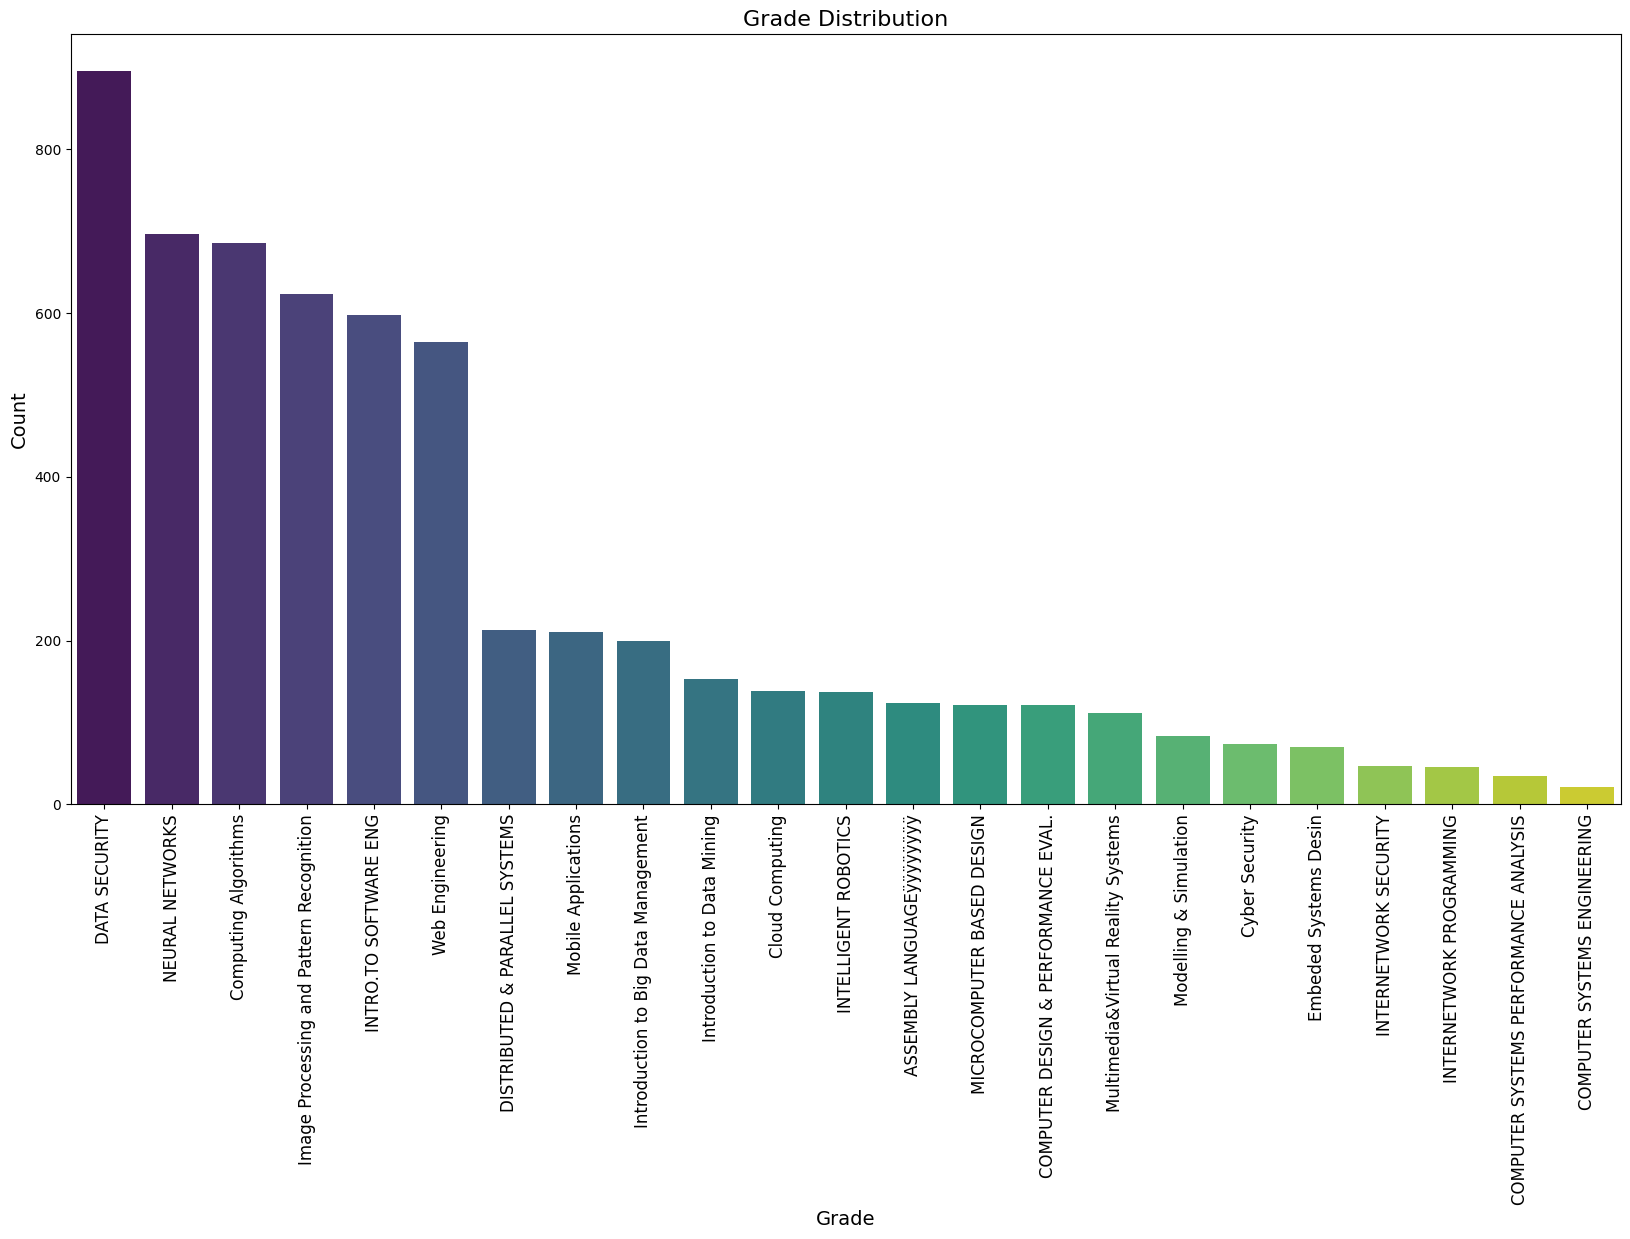

In [452]:
plt.figure(figsize=(20,10))
sns.barplot(x=courses_count.index, y=courses_count.values, palette="viridis")


plt.title("Grade Distribution", fontsize=16)
plt.xlabel("Grade", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=90, fontsize=12)

plt.show()

## **grades distribution**


In [453]:
grades_count=dataset['Grade'].value_counts()
grades_count

,count
Grade,
A+,937
A-,779
B+,769
A,748
B,615
B-,552
C+,411
C,335
D,262


<ipython-input-454-f447c1054669>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=grades_count.index, y=grades_count.values, palette="viridis")


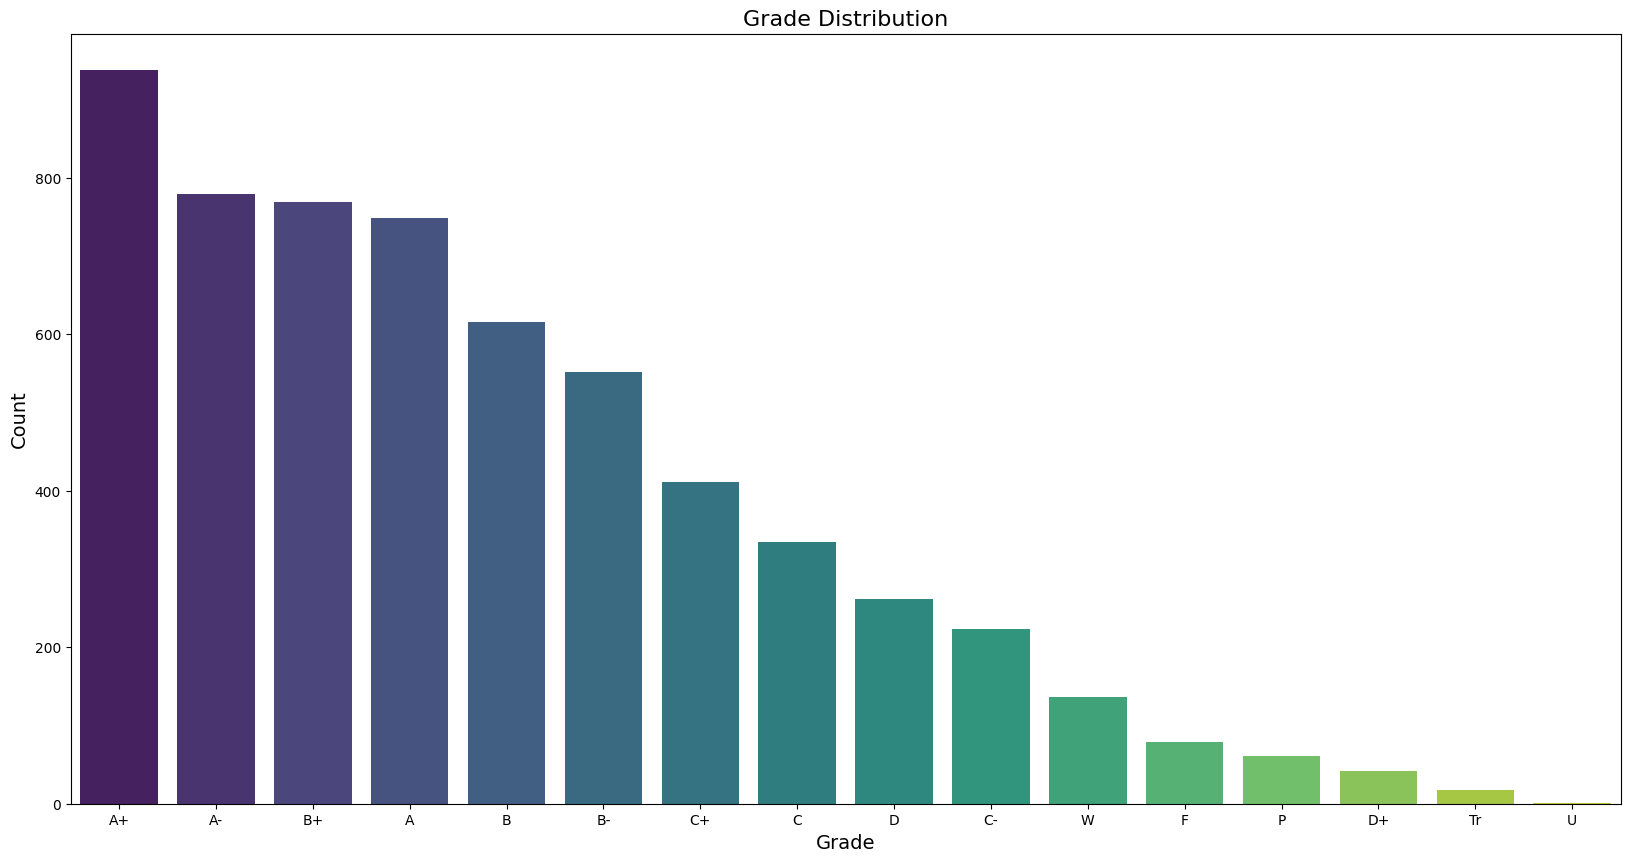

In [454]:
plt.figure(figsize=(20,10))
sns.barplot(x=grades_count.index, y=grades_count.values, palette="viridis")


plt.title("Grade Distribution", fontsize=16)
plt.xlabel("Grade", fontsize=14)
plt.ylabel("Count", fontsize=14)

plt.show()

**Show Grades perecentages**

In [455]:
grades_count_percentage=(grades_count/(dataset.shape[0]))*100
grades_count_percentage

,count
Grade,
A+,15.697772
A-,13.050762
B+,12.883230
A,12.531412
B,10.303233
B-,9.247780
C+,6.885575
C,5.612330
D,4.389345


**final grade distribution**

<ipython-input-456-84326d18d356>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dataset['total'], shade=True, color='skyblue', alpha=0.6)


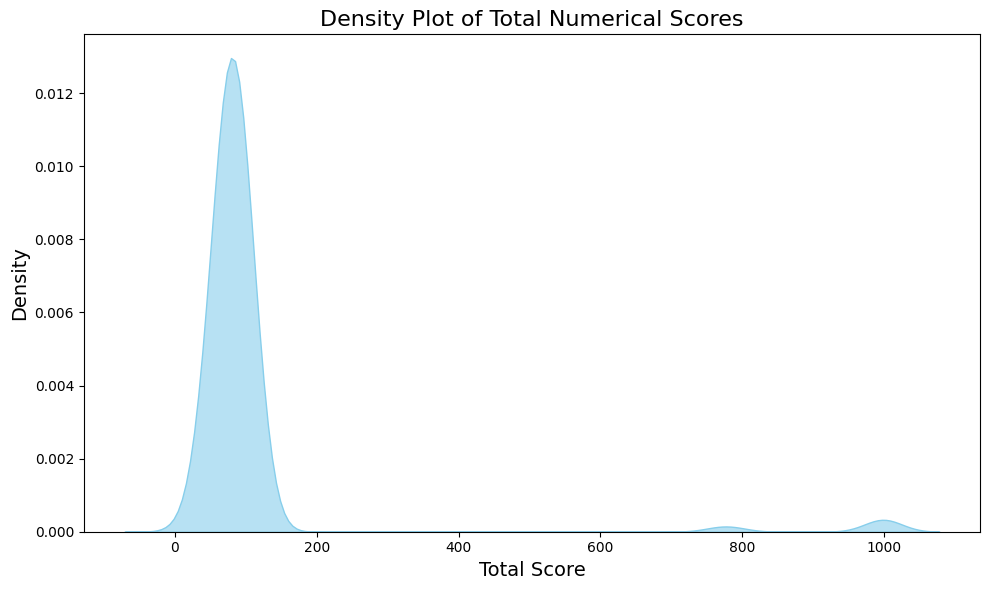

In [456]:

plt.figure(figsize=(10, 6))
sns.kdeplot(dataset['total'], shade=True, color='skyblue', alpha=0.6)
plt.title("Density Plot of Total Numerical Scores", fontsize=16)
plt.xlabel("Total Score", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.tight_layout()
plt.show()


In [457]:
dataset['total'].describe()

,total
count,5969.000000
mean,106.416669
std,149.979668
min,8.000000
25%,70.500000
50%,82.000000
75%,92.000000
max,999.000000


**Grades for students having final score>100**

In [458]:
outliers=dataset[dataset['total'] > 100]
outliers_count=outliers['Grade'].value_counts()
outliers_count


,count
Grade,
W,137
Tr,18
A+,9
A,5
C+,4
C,4
F,3
B+,3
A-,2


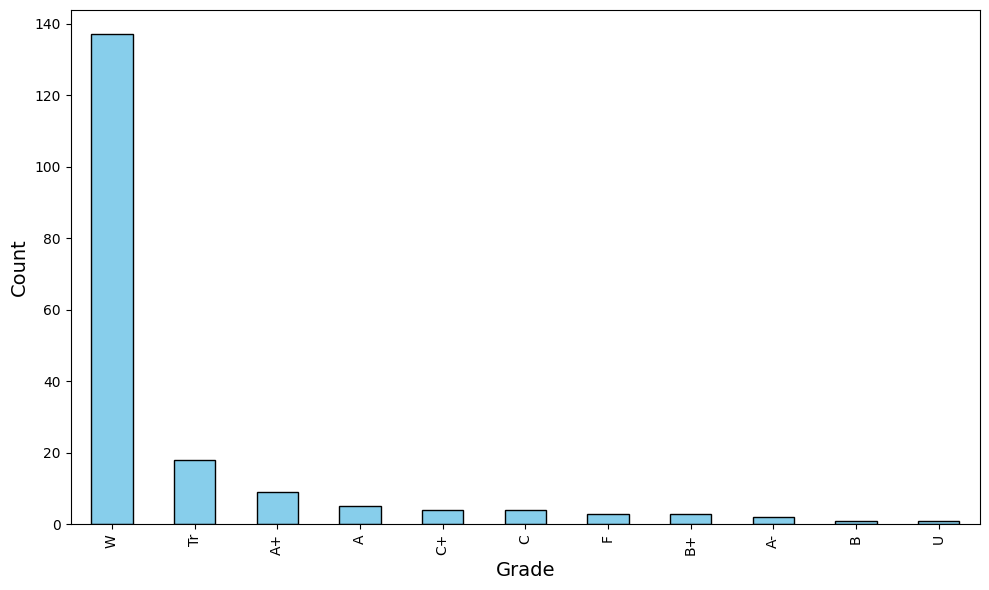

In [459]:
plt.figure(figsize=(10, 6))
outliers_count.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel("Grade", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.tight_layout()
plt.show()

In [460]:
print("portion of the upnoraml values to the total dataset population:",len(outliers)/len(dataset)*100,"%")

portion of the upnoraml values to the total dataset population: 3.132853074216787 %


 # **Cleaning And Preprocessing**

---



## **Removing unecessary columns**

In [461]:
columns_to_drop=['Unnamed: 1','Year','term','Crs Code','7th','12th','year work','final']#only the total numerical grade is Needed in Recommendation process
dataset.drop(columns_to_drop,axis=1,inplace=True)

In [462]:
dataset.columns

Index(['student serial', 'Course Name', 'total', 'Grade'], dtype='object')

## **Removing undefined Grades(outliers)**

**selecting undefined Grades**

In [463]:
#remove records with these Grades Don't Have "Total Final" grade or invalid numerical grades

undefined_grades=['P','Tr','U','I','W']
numbered_undefined_grades=[777,999,888]


**Number of Records to be removed**

In [464]:

undefined=dataset.loc[dataset['Grade'].isin(undefined_grades)|dataset['total'].isin(numbered_undefined_grades)]
print("Number of records with undefined Grades:",undefined.shape[0])

Number of records with undefined Grades: 248


**Records removing**

In [465]:
print("dataset size before dropping upnormal grades:",len(dataset))

dataset size before dropping upnormal grades: 5969


In [466]:
dataset.drop(dataset.loc[dataset['Grade'].isin(undefined_grades)|dataset['total'].isin(numbered_undefined_grades)].index,axis=0,inplace=True)



In [467]:
print("dataset size after dropping upnormal grades:",len(dataset))

dataset size after dropping upnormal grades: 5721


## **statistics after Outliers Removal**

In [468]:
dataset['total'].describe()

,total
count,5721.000000
mean,79.913232
std,13.849235
min,8.000000
25%,70.000000
50%,81.500000
75%,91.000000
max,100.000000


<ipython-input-469-84326d18d356>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dataset['total'], shade=True, color='skyblue', alpha=0.6)


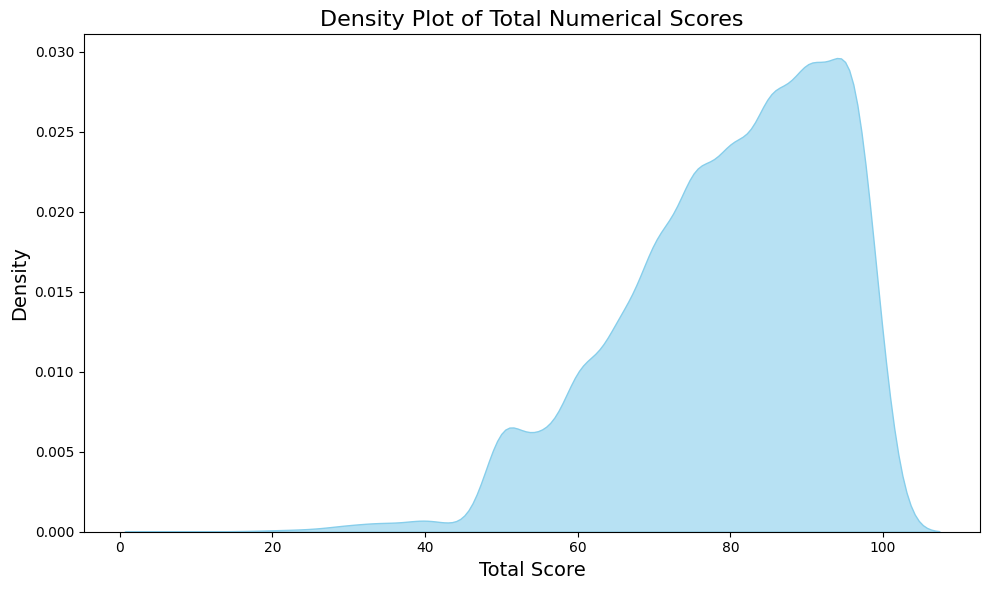

In [469]:

plt.figure(figsize=(10, 6))
sns.kdeplot(dataset['total'], shade=True, color='skyblue', alpha=0.6)
plt.title("Density Plot of Total Numerical Scores", fontsize=16)
plt.xlabel("Total Score", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.tight_layout()
plt.show()


In [470]:
'''
dataset['total_log'] = np.log(dataset['total'])

plt.figure(figsize=(10, 6))
sns.kdeplot(dataset['total_log'], shade=True, color='skyblue', alpha=0.6)
plt.title("Density Plot of Total Numerical Scores", fontsize=16)
plt.xlabel("Total Score", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.tight_layout()
plt.show()
'''

'\ndataset[\'total_log\'] = np.log(dataset[\'total\'])\n\nplt.figure(figsize=(10, 6))\nsns.kdeplot(dataset[\'total_log\'], shade=True, color=\'skyblue\', alpha=0.6)\nplt.title("Density Plot of Total Numerical Scores", fontsize=16)\nplt.xlabel("Total Score", fontsize=14)\nplt.ylabel("Density", fontsize=14)\nplt.tight_layout() \nplt.show()\n'

since data is right skewed a further preprocessing required to improve the model performance towrards students with lower grades...

## **Data Augmentation**

**setting augmentation threshold**

In [471]:
aug_threshold=80

In [472]:
print(f"{(len(dataset[dataset['total'] <= aug_threshold]) / len(dataset)) * 100}% of the data samples have total grade <{aug_threshold}")

47.36934102429645% of the data samples have total grade <80


In [473]:
dataset=augment_data(dataset,'total',aug_threshold,2)#oversampling for datapoints with total grade <80 as the majority of data points are densed only between 80-100

**Distribution after upsampling**

<ipython-input-474-84326d18d356>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dataset['total'], shade=True, color='skyblue', alpha=0.6)


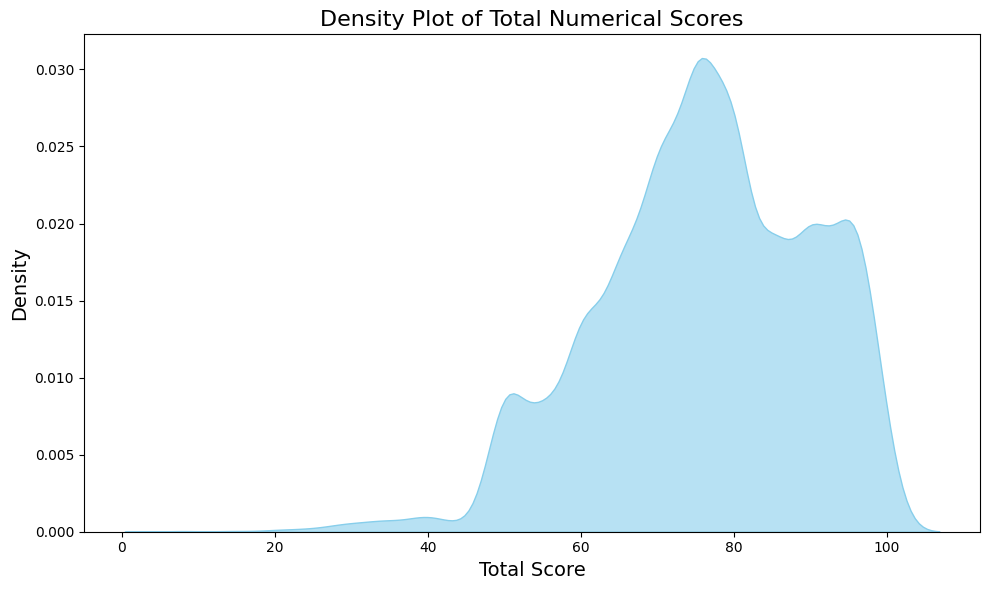

In [474]:

plt.figure(figsize=(10, 6))
sns.kdeplot(dataset['total'], shade=True, color='skyblue', alpha=0.6)
plt.title("Density Plot of Total Numerical Scores", fontsize=16)
plt.xlabel("Total Score", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.tight_layout()
plt.show()


In [475]:
dataset['total'].describe()

,total
count,8431.000000
mean,76.099237
std,13.963178
min,7.261108
25%,66.899204
50%,76.257863
75%,87.000000
max,100.000000


**percent of students with grades<passing threshold**

In [476]:

len(dataset.loc[dataset['total'] < 60])/len(dataset)*100

12.845451310639309

to prevent the model from recommending courses that may lead to failure, it's important to assign higher weights to students with failing grades. This ensures the model is more cautious with their predictions, prioritizing success and avoiding overestimating their chances in challenging courses. This approach helps guide students toward more suitable options and improves their academic outcomes.

In [477]:
dataset.drop(columns=["Grade"], inplace=True)
dataset.head()

,student serial,Course Name,total
0,16260,Computing Algorithms,72.249881
1,16260,Computing Algorithms,71.119060
2,16260,DATA SECURITY,76.418455
3,16260,DATA SECURITY,76.263690
4,16260,INTRO.TO SOFTWARE ENG,75.658366


## **Ecnoding Courses names and Students ID into a continous int values**

this step is neccessary as the neumf model needs continous indecies for creating the latent vectors for both courses and students

In [478]:
students_serial=dataset['student serial'].unique()
courses_name=dataset['Course Name'].unique()
encoded_students_serial = {x: i for i, x in enumerate(students_serial)}
encoded_courses_name = {x: i for i, x in enumerate(courses_name)}

dataset["student_id"] = dataset["student serial"].map(encoded_students_serial)
dataset["course_id"] = dataset["Course Name"].map(encoded_courses_name)

num_students = len(encoded_students_serial)
num_courses = len(encoded_courses_name)

#final Number of Students&courses
print("Number of students:", num_students)
print("Number of courses:", num_courses)


Number of students: 1275
Number of courses: 23


##**Total scores min-max normalization**

In [479]:

#re-arrange columns for simplicity
dataset=dataset[['student_id','course_id','total']]

min_rating = min(dataset["total"])
max_rating = max(dataset["total"])
dataset['total'] = (dataset['total'] - min_rating) / (max_rating - min_rating)#Min-Max nnormalization


<ipython-input-479-cd7a7e27b1a7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['total'] = (dataset['total'] - min_rating) / (max_rating - min_rating)#Min-Max nnormalization


In [480]:
dataset.tail(10)

,student_id,course_id,total
8421,1270,18,0.967651
8422,1270,19,0.881387
8423,1271,14,0.748848
8424,1271,14,0.735695
8425,1272,3,0.924519
8426,1273,1,0.827473
8427,1274,3,0.740912
8428,1274,3,0.734754
8429,1274,20,0.707257
8430,1274,20,0.698362


**Setting Up Training Hyperparameters**


In [481]:
learning_rate=0.001
embedding_size=32
batch_size=8
epochs=100
Top_K=5 #number of items to be recommended




# **Model Architecture**

## **Matrix Factorizor**


**MF-Input_Layer**

In [482]:
students_input=Input(shape=(1,),name='students_input')
courses_input=Input(shape=(1,),name='courses_input')

**MF-embeddings**


In [483]:
mf_students_embeddings=Embedding(num_students,embedding_size,name='mf_students_embeddings')(students_input)
mf_courses_embeddings=Embedding(num_courses,embedding_size,name='mf_courses_embeddings')(courses_input)
mf_courses_embeddings

<KerasTensor shape=(None, 1, 32), dtype=float32, sparse=False, name=keras_tensor_121>

**Matrix Factorization-Layer**

In [484]:
students_vector_mf=Flatten(name='student_vector_mf')(mf_students_embeddings)
courses_vector_mf=Flatten(name='courses_vector_mf')(mf_courses_embeddings)

mf_dot_product=Dot(axes=1,name="mf_dot_product")([students_vector_mf,courses_vector_mf])#MF output

## **MultiLayerPreceptron**


**MLP-Embeddings**

In [485]:
mlp_students_embeddings=Embedding(num_students,embedding_size,name='mlp_students_embeddings')(students_input)
mlp_courses_embeddings=Embedding(num_courses,embedding_size,name='mlp_courses_embeddings')(courses_input)
mlp_courses_embeddings

<KerasTensor shape=(None, 1, 32), dtype=float32, sparse=False, name=keras_tensor_126>

In [486]:
mlp_students_vector=Flatten(name='mlp_student_vector')(mlp_students_embeddings)
mlp_courses_vector=Flatten(name='mlp_courses_vector')(mlp_courses_embeddings)
mlp_concat_vector=Concatenate()([mlp_students_vector,mlp_courses_vector])
mlp_concat_vector

<KerasTensor shape=(None, 64), dtype=float32, sparse=False, name=keras_tensor_129>

**MLP-layer**

In [487]:
layer1=Dense(units=128,activation='relu',name="layer1")(mlp_concat_vector)
layer1_batch_normalization=BatchNormalization(name="layer1_batch_normalization")(layer1)
layer1_drop_out=Dropout(0.5)(layer1_batch_normalization)

layer2=Dense(units=64,activation='relu',name="layer2")(layer1_drop_out)
layer2_batch_normalization=BatchNormalization(name="layer2_batch_normalization")(layer2)
layer2_drop_out=Dropout(0.5)(layer2_batch_normalization)

layer3=Dense(units=32,activation='relu',name="layer3")(layer2_drop_out)


## **NeuMF-Model**

In [488]:
neumf_layer=Concatenate()([mf_dot_product,layer3])
neumf_drop_out=Dropout(0.5)(neumf_layer)
out=Dense(units=1,activation='relu',name="out")(neumf_drop_out)

# **Training**

**Train/Test Splitting**


In [489]:
train,validation = train_test_split(dataset, test_size=0.20, random_state=43)

print(f"Training Samples Size:{train.shape[0]}")
print(f"Validation Samples Size:{validation.shape[0]}.")

Training Samples Size:6744
Validation Samples Size:1687.


In [490]:
train_inputs = [train['student_id'], train['course_id']]
train_target = train['total']

validation_inputs = [validation['student_id'], validation['course_id']]
validation_target = validation['total']

early_stopping = EarlyStopping(monitor='val_loss',verbose=1, restore_best_weights=True,patience=4)


**Samples weighting for training**

In [491]:
weights = np.where(train_target <= 0.6,4, 1)  # Higher weight for 'total' <= 60 (Failed) as we don't want to recommend courses with high likelhood of failure


**Model Creation**

In [492]:
model=Model(inputs=[students_input,courses_input],outputs=out,name="model")
model.compile(optimizer=Adam(learning_rate=learning_rate),loss="MAE")
model.summary()

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ students_input            │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ courses_input             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mlp_students_embeddings   │ (None, 1, 32)          │         40,800 │ students_input[0][0]   │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mlp_courses_embeddings    │ (None, 1, 32)          │            736 │ courses_input[0][0]    │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mlp_student_vector        │ (None, 32)             │              0 │ mlp_students_embeddin… │
│ (Flatten)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mlp_courses_vector        │ (None, 32)             │              0 │ mlp_courses_embedding… │
│ (Flatten)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_12            │ (None, 64)             │              0 │ mlp_student_vector[0]… │
│ (Concatenate)             │                        │                │ mlp_courses_vector[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer1 (Dense)            │ (None, 128)            │          8,320 │ concatenate_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer1_batch_normalizati… │ (None, 128)            │            512 │ layer1[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_18 (Dropout)      │ (None, 128)            │              0 │ layer1_batch_normaliz… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer2 (Dense)            │ (None, 64)             │          8,256 │ dropout_18[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mf_students_embeddings    │ (None, 1, 32)          │         40,800 │ students_input[0][0]   │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mf_courses_embeddings     │ (None, 1, 32)          │            736 │ courses_input[0][0]    │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer2_batch_normalizati… │ (None, 64)             │            256 │ layer2[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 102,530 (400.51 KB)

 Trainable params: 102,146 (399.01 KB)

 Non-trainable params: 384 (1.50 KB)

In [493]:
#pip install tensorflow-gpu


In [494]:
'''import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))'''

"import tensorflow as tf\nprint(tf.config.list_physical_devices('GPU'))"

**Training Loop**

In [495]:
#with tf.device('/GPU:0'):
history = model.fit(x=train_inputs, y=train_target, batch_size=batch_size, epochs=epochs,
                    validation_data=(validation_inputs, validation_target), verbose=1,callbacks=[early_stopping],sample_weight =weights)

Epoch 1/100
843/843 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 1.0153 - val_loss: 0.7452
Epoch 2/100
843/843 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.9732 - val_loss: 0.6669
Epoch 3/100
843/843 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.8875 - val_loss: 0.3422
Epoch 4/100
843/843 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.3823 - val_loss: 0.1601
Epoch 5/100
843/843 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2007 - val_loss: 0.1394
Epoch 6/100
843/843 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1838 - val_loss: 0.1228
Epoch 7/100
843/843 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1685 - val_loss: 0.1218
Epoch 8/100
843/843 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1556 - val_loss: 0.1137
Epoch 9/100
843/843 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1542 - val_loss: 0.1072
Epoch 10/100
843/843 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1505 - val_loss: 0.1092
Epoch 11/100
843/843 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1467 - val_loss: 0.1070
Epoch 12/100
843/843 ━━━━━━━━━━━━━━━━━━━━

In [496]:
model=history.model
validation['prediction']=model.predict(x=validation_inputs)

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


**save model for deployment**

In [424]:
#model.save('/kaggle/working/ReccomenderPrototype.h5')

# **Evaluation**

## **Plotting Losses**

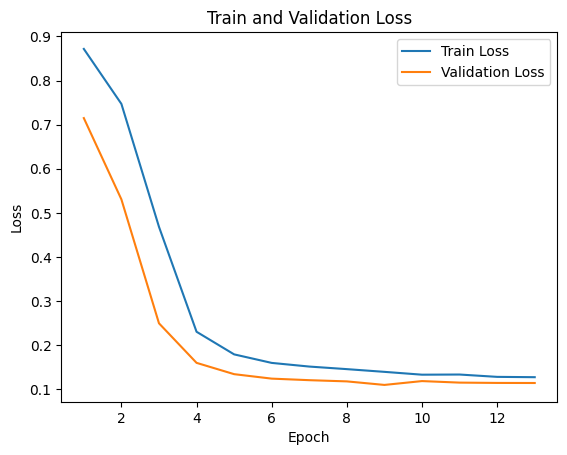

In [425]:

total_epochs = len(history.history['loss'])

epochz = np.arange(1, total_epochs + 1)

train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the train and test losses
plt.plot(epochz, train_loss, label='Train Loss')
plt.plot(epochz, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()


In [ ]:

#history = model.fit(x=validation_inputs, y=validation_target, batch_size=batch_size, epochs=epochs,
  #                 validation_data=(validation_inputs, validation_target), verbose=1, callbacks=[early_stopping])


In [500]:
model=history.model
dataset['prediction']=model.predict(x=[dataset['student_id'],dataset['course_id']])

264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


## **Predicted Vs Actual**

In [501]:
dataset.head()

,student_id,course_id,total,prediction
0,0,0,0.700772,0.728993
1,0,0,0.688578,0.728993
2,0,1,0.745721,0.732092
3,0,1,0.744052,0.732092
4,0,2,0.737525,0.733621


##**Plotting HitRate @K curve**

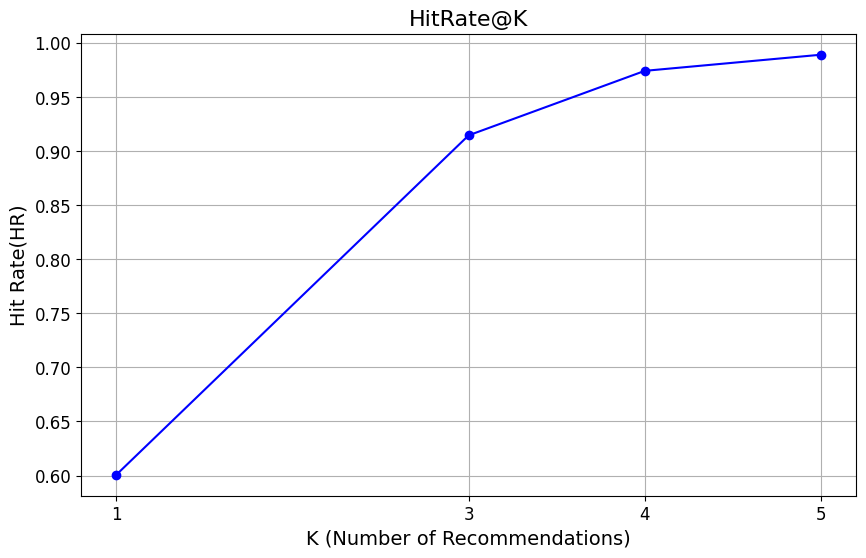

In [435]:
top_k_values = [1,3,4,5]
hit_rates = calculate_hitrate_at_k(dataset, top_k_values)




plt.figure(figsize=(10, 6))
plt.plot(top_k_values, hit_rates, marker='o', linestyle='-', color='b')
plt.title("HitRate@K", fontsize=16)
plt.xlabel("K (Number of Recommendations)", fontsize=14)
plt.ylabel("Hit Rate(HR)", fontsize=14)
plt.xticks(top_k_values, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()


## **sample predictions for lower Grades**




In [502]:
filtered_rows = validation[validation['total'] < 0.6]
filtered_rows.head(20)

,student_id,course_id,total,prediction
2592,348,12,0.468337,0.506443
263,38,3,0.507228,0.530016
3455,447,4,0.530518,0.618093
1887,268,3,0.506259,0.525595
2483,337,0,0.505160,0.599946
1539,224,3,0.527646,0.572724
1350,201,4,0.515882,0.559665
5274,668,15,0.261388,0.458715
51,7,1,0.469054,0.516409
6686,848,21,0.566626,0.563261


## **actual vs predicted for a random student**

In [503]:
target_student=random.choice(validation['student_id'].unique())
prefered_courses=validation.loc[validation['student_id'] == target_student].sort_values(by='total', ascending=False)
prefered_courses.head()

,student_id,course_id,total,prediction
1885,267,2,0.618356,0.467126
1877,267,6,0.516570,0.550072
1879,267,7,0.466612,0.535118
1878,267,7,0.450419,0.535118


## **Plotting actual vs Predicted**



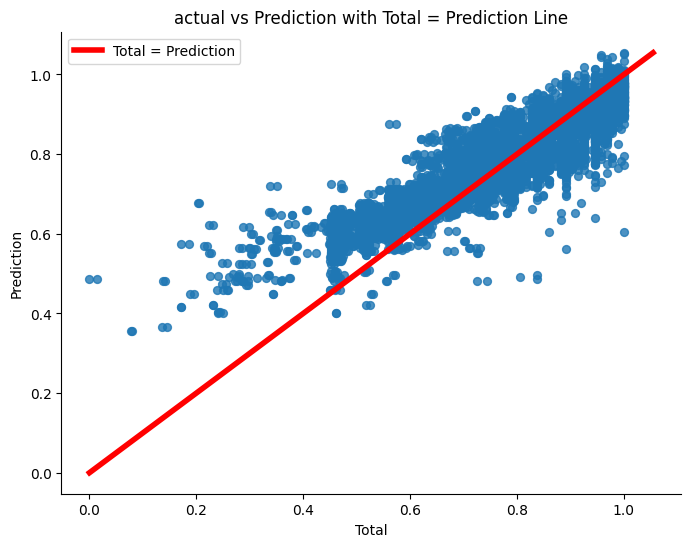

In [504]:


plt.figure(figsize=(8, 6))
plt.scatter(dataset['total'], dataset['prediction'], s=32, alpha=0.8)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# range where total equals prediction
min_val = min(dataset['total'].min(), dataset['prediction'].min())
max_val = max(dataset['total'].max(), dataset['prediction'].max())


plt.plot([min_val, max_val], [min_val, max_val], color='red', linewidth=4, label='Total = Prediction')#total=predicted_line


plt.xlabel('Total')
plt.ylabel('Prediction')
plt.title('actual vs Prediction with Total = Prediction Line')
plt.legend()

plt.show()


# **Inference**

In [433]:
dataset.head()

,student_id,course_id,total,prediction
0,0,0,0.696942,0.717652
1,0,1,0.742556,0.758504
2,0,2,0.719467,0.773395
3,0,3,0.732792,0.743080
4,1,2,0.676668,0.674517


**sample recommendation list for student #20**

In [508]:
student_input=20
courses=dataset['course_id'].unique()

get_topk_recommendations(model, student_input, courses).map(lambda x:courses_name[x]).tolist()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


['DATA SECURITY',
 'Multimedia&Virtual Reality Systems',
 'COMPUTER SYSTEMS PERFORMANCE ANALYSIS',
 'Web Engineering',
 'INTRO.TO SOFTWARE ENG']